ASSIGNMENT 1: SPARK

# Kaggle: Spooky Author Identification
- https://www.kaggle.com/competitions/spooky-author-identification

Competition Task: Predict the author of excerpts from horror stories by Edgar Allan Poe, Mary Shelley, and HP Lovecraft.

Competition Files:
- train.csv (training dataset 3.14 MB)
- test.csv (test dataset 1.28 MB)

Data Fields:
- The training dataset has 3 fields:
  - id (String): unique identifier
  - text (String): text excerpt by one of the named authors
  - author (String): author of the given text excerpt (EAP, MWS, HPL)

## 1. Project Setup

1.1 Spark Session Initialisation

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("SpookyAuthorIdentification").getOrCreate()

# spark.sparkContext.setLogLevel("ALL")
print(f"Spark {spark.version} session initialised!!")

Spark 3.5.3 session initialised!!


1.2 Inspect Spooky Files

Preview train.csv and test.csv before loading and defining schemas

The train.csv file reveals 3 columns:
- id
- text
- author

In [2]:
# Preview train.csv structure
spark.read.csv("../data/train.csv", header=True, inferSchema=True).show(5)

+-------+--------------------+------+
|     id|                text|author|
+-------+--------------------+------+
|id26305|This process, how...|   EAP|
|id17569|It never once occ...|   HPL|
|id11008|In his left hand ...|   EAP|
|id27763|How lovely is spr...|   MWS|
|id12958|Finding nothing e...|   HPL|
+-------+--------------------+------+
only showing top 5 rows



While test.csv file has only 2 columns:

- id
- text



In [3]:

# Preview test.csv structure
spark.read.csv("../data/test.csv", header=True, inferSchema=True).show(5)

+-------+--------------------+
|     id|                text|
+-------+--------------------+
|id02310|Still, as I urged...|
|id24541|If a fire wanted ...|
|id00134|And when they had...|
|id27757|While I was think...|
|id04081|I am not sure to ...|
+-------+--------------------+
only showing top 5 rows



1.3 Project Imports

In [4]:
# PySpark SQL - data types and SQL functions 
from pyspark.sql.types import StructType, StructField, StringType # Schema definition
from pyspark.sql.functions import col, length, avg, stddev, min, max, explode, split, lower, trim
 
# Pyspark Machine Learning - ml features, algorithms, and evaluation
from pyspark.ml.feature import Tokenizer, RegexTokenizer, StopWordsRemover, CountVectorizer, IDF, StringIndexer
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, NaiveBayes
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.functions import vector_to_array

# Data Visualisation - plotting and word clouds
import matplotlib.pyplot as plt
from wordcloud import WordCloud

1.4 Define Schemas

We could use Sparks infer schema here, but it's best practice to manually define the schema.

In [5]:
# Train.csv
trainSchema = StructType([
    StructField("id", StringType(), True),
    StructField("text", StringType(), True),
    StructField("author", StringType(), True)
])

# Test.csv (no author)
testSchema = StructType([
    StructField("id", StringType(), True),
    StructField("text", StringType(), True)
])

1.5 Create Dataframes

Load & Show Data

In [6]:

# File paths (kaggle files uploaded to Databrickss)
trainPath = "../data/train.csv"
testPath = "../data/test.csv"
# File type being read
fileType = "csv"
# Load kaggle train.csv into Dataframe
k_trainDF = (
    spark.read.format(fileType)
        .option('header', 'true')
        .option('escape', '"') # ensures csv is read by spark correctly
        .option('quote', '"')
        .option('multiLine', 'true')
        .schema(trainSchema)
        .load(trainPath)
)

# Load kaggle test.csv into Dataframe
k_testDF = (
    spark.read.format(fileType)
        .option('header', 'true')
        .option('escape', '"')
        .schema(testSchema)
        .load(testPath)
)

# Quick check Dataframes before caching
k_trainDF.show(5, truncate=70) # show max 70 chars per field
k_testDF.show(5, truncate=70)

k_trainDF.printSchema()
k_testDF.printSchema()

+-------+----------------------------------------------------------------------+------+
|     id|                                                                  text|author|
+-------+----------------------------------------------------------------------+------+
|id26305|This process, however, afforded me no means of ascertaining the dim...|   EAP|
|id17569|It never once occurred to me that the fumbling might be a mere mist...|   HPL|
|id11008|In his left hand was a gold snuff box, from which, as he capered do...|   EAP|
|id27763|How lovely is spring As we looked from Windsor Terrace on the sixte...|   MWS|
|id12958|Finding nothing else, not even gold, the Superintendent abandoned h...|   HPL|
+-------+----------------------------------------------------------------------+------+
only showing top 5 rows

+-------+----------------------------------------------------------------------+
|     id|                                                                  text|
+-------+------------

1.6 Verify Data Integrity

Basic integrity check before deeper data analysis and normalisation

In [7]:

# check for null or empty values
trainNullCheck = k_trainDF.filter(
    (col("text").isNull()) | (col("text") == "") | (col("author").isNull())
)
testNullCheck = k_testDF.filter(
    (col("text").isNull()) | (col("text") == "")
)

print("Null check train dataframe:", trainNullCheck.count())
print("Null check test dataframe:", testNullCheck.count())

# Check for duplicate rows in training dataset
dupeCheckDF = (
    k_trainDF
        .groupBy("text", "author")
        .count()
        .where(col("count") > 1)
)

print("Check for duplicate values: ")
dupeCheckDF.show()

# Row count
print("Train dataframe row count: ", k_trainDF.count())
print("Test dataframe row count: ", k_testDF.count())

# No null, empty or duplicate values were found

# Check partitioning allocated
print("Number of partitions in Kaggle trainDF:", k_trainDF.rdd.getNumPartitions())
print("Number of partitions in Kaggle testDF:", k_testDF.rdd.getNumPartitions())

""" 
Sparks partitioning system usually automatically splits data into 8 partitions.
In this case, it hasn't as the train dataset is only 3.14 MB (extremely small for Spark!). 
I have forcibly repartitioned the train dataframe into 8 partitions.
However, for such a small dataset this won't provide any extra performance benefits and is just for demonstration purposes.
"""
k_trainDF = k_trainDF.repartition(8)
print("Number of partitions in Kaggle trainDF:", k_trainDF.rdd.getNumPartitions())

Null check train dataframe: 0
Null check test dataframe: 0
Check for duplicate values: 
+----+------+-----+
|text|author|count|
+----+------+-----+
+----+------+-----+

Train dataframe row count:  19579
Test dataframe row count:  8392
Number of partitions in Kaggle trainDF: 1
Number of partitions in Kaggle testDF: 1
Number of partitions in Kaggle trainDF: 8


1.7 Caching

Cache the training dataframe as it will undergo multiple transformations

In [8]:

k_trainDF.cache()
print("k_trainDF dataframe has been cached!")

k_trainDF dataframe has been cached!


## 2. Data Exploration

2.1 Author Exploration

In [9]:

print("====== Distinct Authors ======")
k_trainDF.select("author").distinct().show()

print("====== Distribution of Entries by Author ======")
authorDistributionDF = (
    k_trainDF
        .groupBy("author")
        .count()
        .orderBy(col("count").desc())
)
authorDistributionDF.show()

====== Distinct Authors ======
+------+
|author|
+------+
|   MWS|
|   HPL|
|   EAP|
+------+

====== Distribution of Entries by Author ======
+------+-----+
|author|count|
+------+-----+
|   EAP| 7900|
|   MWS| 6044|
|   HPL| 5635|
+------+-----+



Author Distribution: Bar Chart

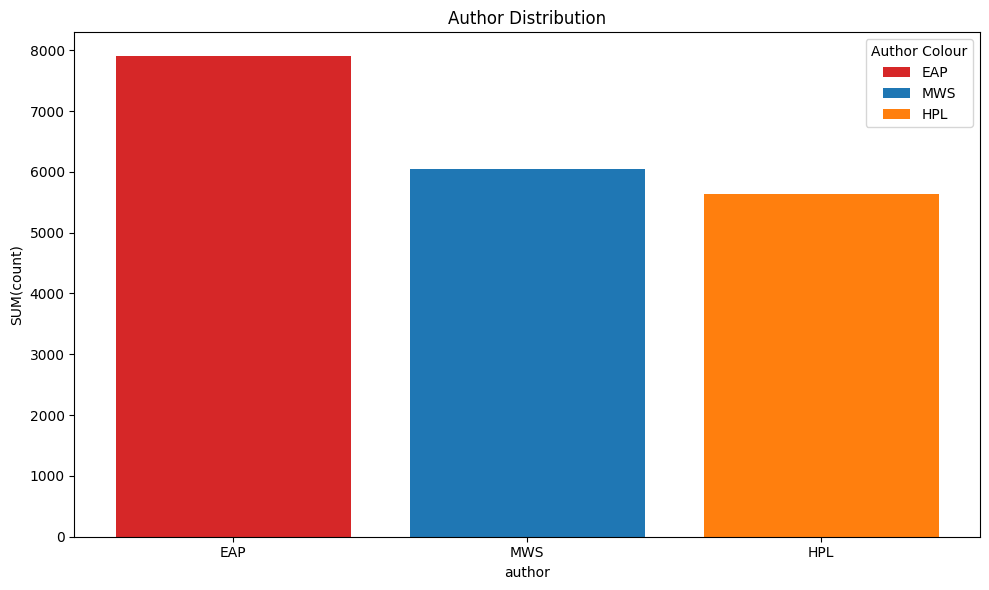

In [10]:

# Convert to pandas dataframe
authorDistributionPD = authorDistributionDF.toPandas()


# Create figure and axis
fig, ax = plt.subplots(figsize=(10,6))

# Data
authors = authorDistributionPD['author']
counts = authorDistributionPD['count']
bar_labels = ['EAP', 'MWS', 'HPL']
bar_colors = ['tab:red', 'tab:blue', 'tab:orange']

# Create bar chart
ax.bar(authors, counts, label=bar_labels, color=bar_colors)

ax.set_ylabel('SUM(count)')
ax.set_xlabel('author')
ax.set_title('Author Distribution')
ax.legend(title='Author Colour')

plt.tight_layout()
plt.show()


2.2 Text Exploration

In [ ]:
# Create copy of dataframe 'with column' textLen
textExplorationDF = (
    k_trainDF
        .withColumn("textLen", length(col("text")))
        .select("id", "author", "text", "textLen")
)

print("====== Longest Excerpts -> descending ======")
textExplorationDF.orderBy(col("textLen").desc()).show(10)

print("====== Shortest Excerpts -> ascending ======")
textExplorationDF.orderBy(col("textLen").asc()).show(10)

print("====== TextLen Column Stats ======")
textExplorationDF.select("textLen").describe().show()

"""
Findings:
- 19,579 text excerpts
- Longest text excerpt is 4,663 characters
- Shortest text excerpt is 21 characters
- Average text excerpt length is approx 149 characters
- Standard deviation in lenghth is appox 107 characters 
- The top 5 longest excerpts all belong to Mary Shelley (MWS)
- The very long text excerpts appear to be outliers, 
  the majority of entries are below 1000 characters
"""

====== Longest Excerpts -> descending ======
+-------+------+--------------------+-------+
|     id|author|                text|textLen|
+-------+------+--------------------+-------+
|id27184|   MWS|Diotima approache...|   4663|
|id17485|   MWS|Oh no I will beco...|   3048|
|id13677|   MWS|They are gone for...|   2275|
|id20439|   MWS|To chambers of pa...|   2200|
|id20549|   MWS|As for those who ...|   1849|
|id12818|   EAP|Burning with the ...|   1533|
|id20687|   EAP|I have much to sa...|   1523|
|id24207|   MWS|At first indeed t...|   1032|
|id19267|   MWS|This also was my ...|    995|
|id03319|   MWS|I invited him to ...|    993|
|id02143|   MWS|Oh God help me Le...|    983|
|id23272|   EAP|awful calamity wa...|    964|
|id06581|   MWS|They were certain...|    948|
|id05745|   MWS|It was in Rome th...|    924|
|id25287|   EAP|It should be reme...|    910|
|id04831|   EAP|To muse for long ...|    908|
|id14957|   HPL|A weak, filtered ...|    900|
|id24339|   MWS|He seemed incapab..

'\nFindings:\n- 19,579 text excerpts\n- Longest text excerpt is 4,663 characters\n- Shortest text excerpt is 21 characters\n- Average text excerpt length is approx 149 characters\n- Standard deviation in lenghth is appox 107 characters \n- The top 5 longest excerpts all belong to Mary Shelley (MWS)\n- The very long text excerpts appear to be outliers, \n  the majority of entries are below 1000 characters\n'

2.3 Text Length Distribution by Author

In [12]:
authorStatsDF = (
    textExplorationDF
        .groupBy("author")
        .agg(
            avg("textLen").alias("avgTxtLen"),
            stddev("textLen").alias("stdTxtLen"),
            min("textLen").alias("minTxtLen"),
            max("textLen").alias("maxTxtLen"))
        .orderBy(col("avgTxtLen").desc())
)

print("====== Distribution of Text Length by Author ======")
authorStatsDF.show()

"""
Findings:
- Average text length approximately the same across authors, ranging from 142 to 156 
  characters
- Standard deviation is considerably higher for MWS (127) - EAP (106), HPL (82)
- Min text Length is the same for all authors
"""

====== Distribution of Text Length by Author ======
+------+------------------+------------------+---------+---------+
|author|         avgTxtLen|         stdTxtLen|minTxtLen|maxTxtLen|
+------+------------------+------------------+---------+---------+
|   HPL|155.84347826086957| 82.02064723110335|       21|      900|
|   MWS|151.65982792852415|126.30500751783727|       21|     4663|
|   EAP|142.22594936708862|105.75133420774067|       21|     1533|
+------+------------------+------------------+---------+---------+



'\nFindings:\n- Average text length approximately the same across authors, ranging from 142 to 156 \n  characters\n- Standard deviation is considerably higher for MWS (127) - EAP (106), HPL (82)\n- Min text Length is the same for all authors\n'

2.4 Word Frequency

In [36]:
wordsDF =(
    textExplorationDF
    # explode text excerpts into single words
    .select("author", explode(split(col("text"), " ")).alias("rawWord"))
    # Convert to lowercase, trim whitespace
    .select("author", lower(trim(col("rawWord"))).alias("word"))
    # Ignore empty strings
    .filter(col("word")!="")
)

topWordsDF = (
    wordsDF
        .groupBy("word")
        .count()
        .orderBy(col("count").desc())
)
print("====== Top 20 Most Common Words ======")
topWordsDF.show(20)

topWordsByAuthorDF =(
    wordsDF
        .groupBy("author", "word")
        .count()
        .orderBy(col("count").desc())
)
print("====== Top 20 Most Common Words by Author ======")
topWordsByAuthorDF.show(20)

====== Top 20 Most Common Words ======
+-----+-----+
| word|count|
+-----+-----+
|  the|35425|
|   of|20931|
|  and|17507|
|   to|12778|
|    a|10672|
|    i|10383|
|   in| 9383|
|  was| 6471|
| that| 6142|
|   my| 5367|
|  had| 4369|
| with| 4334|
|   he| 4286|
|   it| 4129|
|  his| 4073|
|   as| 3802|
|  for| 3437|
|   at| 3207|
|which| 3206|
|  but| 3144|
+-----+-----+
only showing top 20 rows

====== Top 20 Most Common Words by Author ======
+------+----+-----+
|author|word|count|
+------+----+-----+
|   EAP| the|14887|
|   HPL| the|10923|
|   MWS| the| 9615|
|   EAP|  of| 8961|
|   MWS|  of| 6134|
|   HPL| and| 6090|
|   MWS| and| 6002|
|   HPL|  of| 5836|
|   EAP| and| 5415|
|   MWS|  to| 4812|
|   EAP|  to| 4722|
|   EAP|   a| 4674|
|   MWS|   i| 4155|
|   EAP|  in| 4086|
|   EAP|   i| 3599|
|   HPL|   a| 3293|
|   HPL|  to| 3244|
|   HPL|  in| 2713|
|   MWS|   a| 2705|
|   MWS|  my| 2632|
+------+----+-----+
only showing top 20 rows



Word Frequencey (top 20): Bar Chart

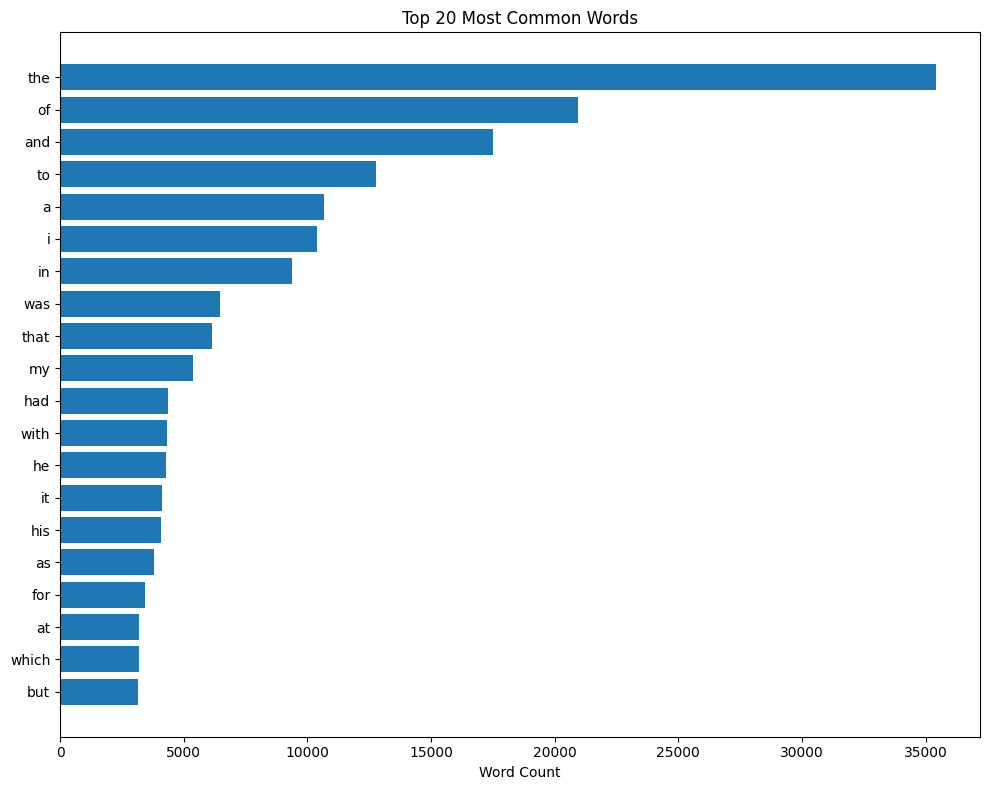

In [14]:

# Convert to pandas dataframe
topWordsPD = topWordsDF.limit(20).toPandas()

# Create figure and axis
fig, ax = plt.subplots(figsize=(10,8))

# Example data
words = topWordsPD['word']
y_pos = range(len(words))
wordCounts = topWordsPD['count']

# Create horizontal bar chart
ax.barh(y_pos, wordCounts, align='center')
ax.set_yticks(y_pos, labels=words)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Word Count')
ax.set_title('Top 20 Most Common Words')

plt.tight_layout()
plt.show()

## 3. Data Preparation & Feature Engineering
- Demonstration of a basic pipeline
- Sequential creation and testing of each feature
- Logistic Regression is manually implemented as final modelling step for testing    
  purposes

3.1 Split Training Dataset

Train/Validate Split 70/30


In [15]:
trainDF, valDF = k_trainDF.randomSplit([0.7, 0.3], seed=42)
trainDF.cache()
valDF.cache()

print("====== k_trainDF Split ======")
print("The original kaggle dataframe:", k_trainDF.count(), "rows")
print("trainDF:", trainDF.count(), "rows -", trainDF.count()/k_trainDF.count(), "%")
print("testDF:", valDF.count(), "rows -", valDF.count()/k_trainDF.count(), "%")

#  Transformations are done on a copy of trainDF to keep original in tact for final pipeline implementation
demoDF = trainDF.select("*")

====== k_trainDF Split ======
The original kaggle dataframe: 19579 rows
trainDF: 13830 rows - 0.7063690689003524 %
testDF: 5749 rows - 0.2936309310996476 %


3.2 Tokenization
- Plain tokenizer: splits strings on whitespace and returns array of tokens 
- Punctuation is preserveed

In [37]:
# Plain tokenizer - punctuation is preserved
tokenizer = Tokenizer(inputCol="text", outputCol="plainTokens")
tokenizedDF = tokenizer.transform(demoDF)

print("====== Plain Tokenizer Output ======")
tokenizedDF.select("author", "text", "plainTokens").show(10, truncate=30)

====== Plain Tokenizer Output ======
+------+------------------------------+------------------------------+
|author|                          text|                   plainTokens|
+------+------------------------------+------------------------------+
|   EAP|His warehouse was the resor...|[his, warehouse, was, the, ...|
|   HPL|The moribund hermit's rage ...|[the, moribund, hermit's, r...|
|   MWS|Raymond was weak and exhaus...|[raymond, was, weak, and, e...|
|   HPL|As the weeks passed, I obse...|[as, the, weeks, passed,, i...|
|   MWS|Death, cruel and relentless...|[death,, cruel, and, relent...|
|   HPL|An' the smell was awful, li...|[an', the, smell, was, awfu...|
|   HPL|Where if anywhere had he be...|[where, if, anywhere, had, ...|
|   HPL|These responses from aesthe...|[these, responses, from, ae...|
|   HPL|I do not believe I need to ...|[i, do, not, believe, i, ne...|
|   EAP|The author who was much tho...|[the, author, who, was, muc...|
+------+------------------------------+-

3.3 Regex Tokenization
- I ended up using this instead of the plain tokenizer
- Custom regex pattern allows you to define how you want to split the data
- More precision and control

In [50]:

# Use custom regex pattern - punctuation is removed
regexTokenizer =(
    RegexTokenizer(
        inputCol="text",
        outputCol="tokens",
        pattern=r"[^\w']+"  # splits on anything that is not a word char or apostrophe
    )
)

regexTokenizedDF = regexTokenizer.transform(demoDF)
print("====== Regex Tokenizer Output ======")

regexTokenizedDF.select("author", "text", "tokens").show(10, truncate=30)
#regexTokenizedDF.show(10)

====== Regex Tokenizer Output ======
+------+------------------------------+------------------------------+
|author|                          text|                        tokens|
+------+------------------------------+------------------------------+
|   EAP|His warehouse was the resor...|[his, warehouse, was, the, ...|
|   HPL|The moribund hermit's rage ...|[the, moribund, hermit's, r...|
|   MWS|Raymond was weak and exhaus...|[raymond, was, weak, and, e...|
|   HPL|As the weeks passed, I obse...|[as, the, weeks, passed, i,...|
|   MWS|Death, cruel and relentless...|[death, cruel, and, relentl...|
|   HPL|An' the smell was awful, li...|[an', the, smell, was, awfu...|
|   HPL|Where if anywhere had he be...|[where, if, anywhere, had, ...|
|   HPL|These responses from aesthe...|[these, responses, from, ae...|
|   HPL|I do not believe I need to ...|[i, do, not, believe, i, ne...|
|   EAP|The author who was much tho...|[the, author, who, was, muc...|
+------+------------------------------+-

3.4 Stopword Remover
- Default list of english stopwords are removed (e.g. 'the, and, a, as...')
- Can create your own custom stopwords list by appending to the default

In [52]:

customStopWords = StopWordsRemover.loadDefaultStopWords("english") # to customise concat "+ ('word to remove', ...)"
print("====== Default & Custom Stop Words ======")
print(customStopWords)

remover = StopWordsRemover(inputCol="tokens", outputCol="filteredTokens", stopWords=customStopWords)
stopWordsRemovedDF = remover.transform(regexTokenizedDF)

print("====== Tokens Before/After Stopword Removal ======")
stopWordsRemovedDF.select("tokens", "filteredTokens").show(5, truncate=40)

====== Default & Custom Stop Words ======
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', '

Before/After Stopword Removal: Word Clouds

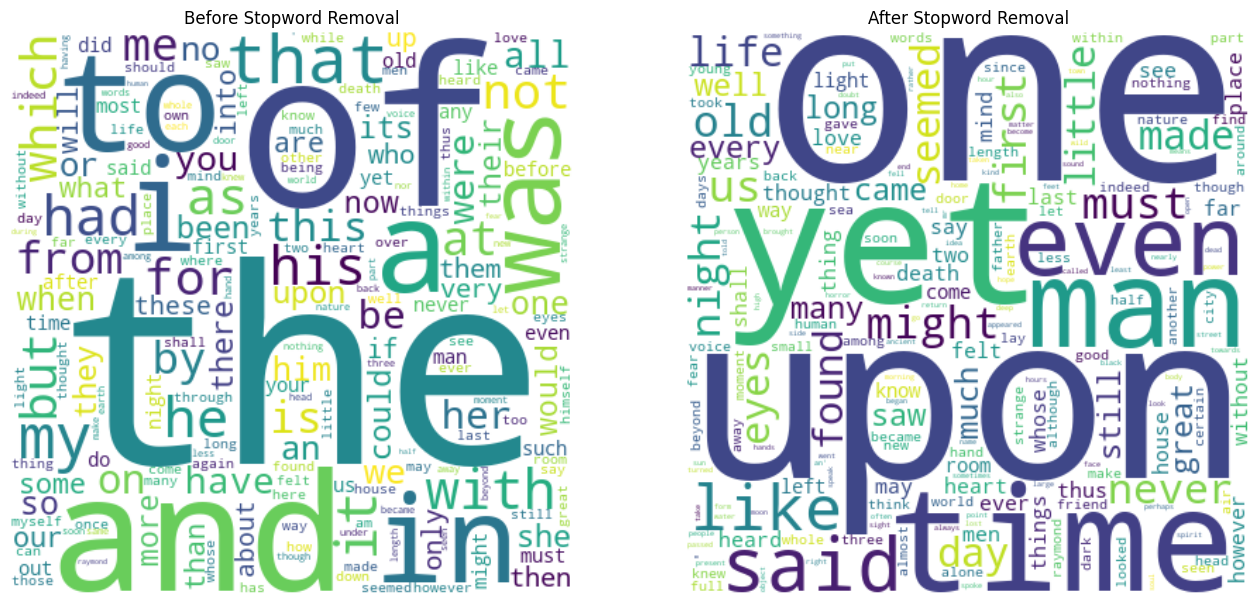

In [19]:

# Before stop words removed
before_stopWordsRemoved = (
    stopWordsRemovedDF
        .select(explode(col("tokens")).alias("beforeTokens"))
        .groupBy("beforeTokens")
        .count()
        .orderBy(col("count").desc())
)

beforePD = before_stopWordsRemoved.toPandas()

# After stop words removed
after_stopWordsRemoved = (
    stopWordsRemovedDF
        .select(explode(col("filteredTokens")).alias("afterTokens"))
        .groupBy("afterTokens")
        .count()
        .orderBy(col("count").desc())
)

afterPD = after_stopWordsRemoved.toPandas()

# Create before and after frequency dictionaries
before_frequency = dict(zip(beforePD['beforeTokens'], beforePD['count']))
after_frequency = dict(zip(afterPD['afterTokens'], afterPD['count']))

# Create side by side word clouds
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))


# Generate Word Cloud images
# 1. Before Word Cloud
before_wc = WordCloud(background_color="white", width=400, height=400)
before_wc.generate_from_frequencies(before_frequency)
ax1.imshow(before_wc, interpolation="bilinear")
ax1.axis("off")
ax1.set_title("Before Stopword Removal")
# 2. After Word Cloud
after_wc = WordCloud(background_color="white", width=400, height=400)
after_wc.generate_from_frequencies(after_frequency)
ax2.imshow(after_wc, interpolation="bilinear")
ax2.axis("off")
ax2.set_title("After Stopword Removal")


# plt.tight_layout()
plt.show()



3.5 Quick Exploration of Filtered Data
- Examined the data once more -- this time with the stopwords removed

In [20]:
# Top tokens
tokensDF = (
    stopWordsRemovedDF
        .select(explode(col("filteredTokens")).alias("token"))
        .groupBy("token")
        .count()
        .orderBy(col("count").desc())
)
print("====== Top 20 Filtered Words (tokens) ======")
tokensDF.show(20)

# Top tokens by authors
tokensByAuthorDF = (
    stopWordsRemovedDF
        .select("author", explode(col("filteredTokens")).alias("token"))
        .groupBy("author","token")
        .count()
        .orderBy(col("count").desc())
)
print("====== Top 20 Filtered Words (tokens) by Author ======")
tokensByAuthorDF.show(20)


====== Top 20 Filtered Words (tokens) ======
+------+-----+
| token|count|
+------+-----+
|   one| 1078|
|  upon|  984|
|   yet|  512|
|  time|  507|
|   man|  491|
|  even|  485|
|  said|  477|
|  like|  440|
| might|  432|
|    us|  428|
|   old|  425|
|  must|  422|
| first|  421|
| night|  404|
| never|  404|
|  made|  390|
|seemed|  388|
|  life|  386|
|  eyes|  381|
|little|  379|
+------+-----+
only showing top 20 rows

====== Top 20 Filtered Words (tokens) by Author ======
+------+------+-----+
|author| token|count|
+------+------+-----+
|   EAP|  upon|  701|
|   EAP|   one|  427|
|   MWS|   one|  330|
|   HPL|   one|  321|
|   HPL|   old|  279|
|   EAP|  said|  233|
|   MWS|  life|  229|
|   MWS|   yet|  225|
|   EAP|little|  214|
|   MWS|    us|  198|
|   MWS|  love|  196|
|   HPL|seemed|  194|
|   EAP|   say|  193|
|   MWS| heart|  188|
|   HPL|  like|  185|
|   MWS|  eyes|  184|
|   EAP|  even|  183|
|   EAP| first|  182|
|   MWS| might|  181|
|   EAP|  time|  181|
+------+

HP Lovecraft (top 100 tokens): Word Cloud

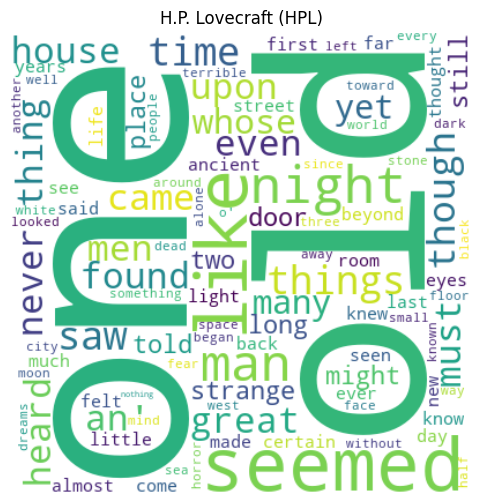

In [21]:

# Top tokens HPL
tokensByHPL =(
    tokensByAuthorDF
        .filter(col("author") == "HPL")
        .orderBy(col("count").desc())
)

hplTokensPD = tokensByHPL.limit(100).toPandas()

# Create token frequency dictionary
hplFrequency = dict(zip(hplTokensPD['token'], hplTokensPD['count']))

# Create word cloud
fig, (ax1) = plt.subplots(1, figsize=(18, 6))


# Generate Word Cloud images
# 1. Before Word Cloud
hpl_wc = WordCloud(background_color="white", width=400, height=400)
hpl_wc.generate_from_frequencies(hplFrequency)
ax1.imshow(hpl_wc, interpolation="bilinear")
ax1.axis("off")
ax1.set_title("H.P. Lovecraft (HPL)")

# plt.tight_layout()
plt.show()



Edgar Allan Poe (top 100 tokens): Word Cloud

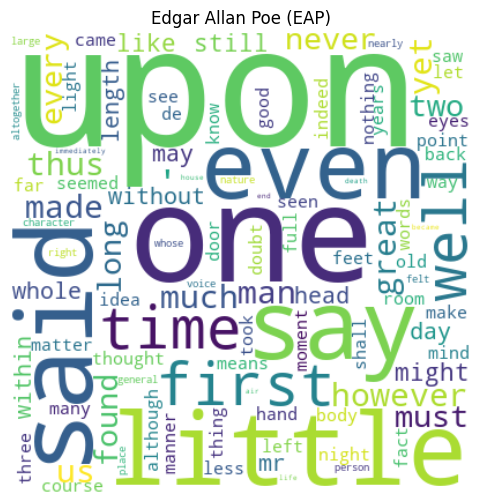

In [22]:

# Top tokens EAP
tokensByEAP =(
    tokensByAuthorDF
        .filter(col("author") == "EAP")
        .orderBy(col("count").desc())
)

eapTokensPD = tokensByEAP.limit(100).toPandas()

# Create token frequency dictionary
eapFrequency = dict(zip(eapTokensPD['token'], eapTokensPD['count']))

# Create word cloud
fig, (ax1) = plt.subplots(1, figsize=(18, 6))


# Generate Word Cloud images
# 1. Before Word Cloud
eap_wc = WordCloud(background_color="white", width=400, height=400)
eap_wc.generate_from_frequencies(eapFrequency)
ax1.imshow(eap_wc, interpolation="bilinear")
ax1.axis("off")
ax1.set_title("Edgar Allan Poe (EAP)")

# plt.tight_layout()
plt.show()

Mary Shelley (top 100 tokens): Word Cloud

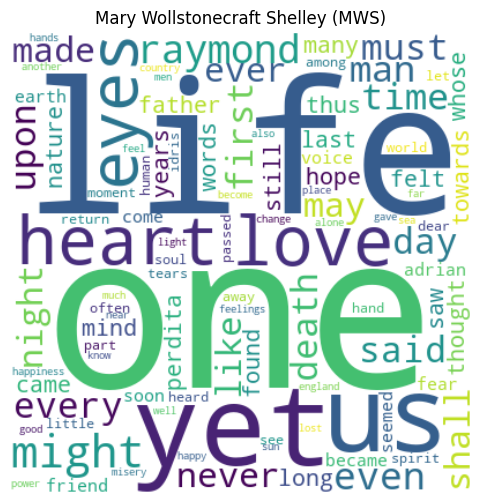

In [23]:

# Top tokens MWS
tokensByMWS =(
    tokensByAuthorDF
        .filter(col("author") == "MWS")
        .orderBy(col("count").desc())
)

mwsTokensPD = tokensByMWS.limit(100).toPandas()

# Create token frequency dictionary
mwsFrequency = dict(zip(mwsTokensPD['token'], mwsTokensPD['count']))

# Create word cloud
fig, (ax1) = plt.subplots(1, figsize=(18, 6))


# Generate Word Cloud images
# 1. Before Word Cloud
mws_wc = WordCloud(background_color="white", width=400, height=400)
mws_wc.generate_from_frequencies(mwsFrequency)
ax1.imshow(mws_wc, interpolation="bilinear")
ax1.axis("off")
ax1.set_title("Mary Wollstonecraft Shelley (MWS)")

plt.show()

3.6 TF-IDF (Term Frequency - Inverse Documentation Frequency)
- A two step process involving CountVectorizer and IDF

Count vectorizer
- Convert filtered tokens into term frequency vectors

In [53]:

# Convert filtered tokens into term frequency vectors
countVec = CountVectorizer(inputCol="filteredTokens", outputCol="termFrequency")
countVec_model = countVec.fit(stopWordsRemovedDF)               # Fit countVec mode
vectorizedDF = countVec_model.transform(stopWordsRemovedDF)     # Tranform Dataframe

print("====== Term Frequency ======")
vectorizedDF.select("filteredTokens", "termFrequency").show(20, truncate=40)

====== Term Frequency ======
+----------------------------------------+----------------------------------------+
|                          filteredTokens|                           termFrequency|
+----------------------------------------+----------------------------------------+
|[warehouse, resort, principal, people...|(22384,[52,128,185,418,1059,1920,2105...|
|[moribund, hermit's, rage, fear, swel...|(22384,[16,18,97,184,231,518,1224,130...|
|[raymond, weak, exhausted, yet, inter...|(22384,[2,94,272,296,304,456,466,527,...|
|[weeks, passed, observed, regret, new...|(22384,[70,89,99,123,281,385,704,878,...|
|[death, cruel, relentless, entered, b...|(22384,[41,226,334,549,2786,4459],[1....|
|[an', smell, awful, like, araound, wi...|(22384,[7,144,1129,2486,2511,3678,510...|
| [anywhere, nights, daemoniac, alienage]|(22384,[2676,3179,6236,11113],[1.0,1....|
|[responses, aesthetes, told, disturbi...|(22384,[127,478,3629,8957,11951],[1.0...|
|[believe, need, wait, full, change, w...|(2238

IDF (Inverse Documentation Frequency)
- Upweight unique words
- Downweight common words

In [54]:

idf = IDF(inputCol="termFrequency", outputCol="tfidfFeatures")
idf_model = idf.fit(vectorizedDF) # fit idf_model
tfidfDF = idf_model.transform(vectorizedDF) # Transform dataframe

print("====== TF-IDF Features ======")
tfidfDF.select("termFrequency", "tfidfFeatures").show(20, truncate=40)

====== TF-IDF Features ======
+----------------------------------------+----------------------------------------+
|                           termFrequency|                           tfidfFeatures|
+----------------------------------------+----------------------------------------+
|(22384,[52,128,185,418,1059,1920,2105...|(22384,[52,128,185,418,1059,1920,2105...|
|(22384,[16,18,97,184,231,518,1224,130...|(22384,[16,18,97,184,231,518,1224,130...|
|(22384,[2,94,272,296,304,456,466,527,...|(22384,[2,94,272,296,304,456,466,527,...|
|(22384,[70,89,99,123,281,385,704,878,...|(22384,[70,89,99,123,281,385,704,878,...|
|(22384,[41,226,334,549,2786,4459],[1....|(22384,[41,226,334,549,2786,4459],[3....|
|(22384,[7,144,1129,2486,2511,3678,510...|(22384,[7,144,1129,2486,2511,3678,510...|
|(22384,[2676,3179,6236,11113],[1.0,1....|(22384,[2676,3179,6236,11113],[6.8956...|
|(22384,[127,478,3629,8957,11951],[1.0...|(22384,[127,478,3629,8957,11951],[4.5...|
|(22384,[111,236,240,632,1077,1700],[1...|(223

3.7 String Indexer
- Assign numeric index values to each unique author
- Authors are labelled from 0 to 1, 0 being most frequent and 2 least

In [26]:

si = StringIndexer(inputCol="author", outputCol="authorIndex")
si_model = si.fit(tfidfDF) # fit string indexer model
indexedDF = si_model.transform(tfidfDF) # Transform dataframe

print("====== Author String Indexing ======")
indexedDF.select("author", "authorIndex").show(10)

print("====== Label Order ======")
print(si_model.labels)

"""
String Indexing Label Ordering: ['EAP', 'MWS', 'HPL']
EAP -> 0
MWS -> 1
HPL -> 2
"""

====== Author String Indexing ======
+------+-----------+
|author|authorIndex|
+------+-----------+
|   EAP|        0.0|
|   HPL|        2.0|
|   MWS|        1.0|
|   HPL|        2.0|
|   MWS|        1.0|
|   HPL|        2.0|
|   HPL|        2.0|
|   HPL|        2.0|
|   HPL|        2.0|
|   EAP|        0.0|
+------+-----------+
only showing top 10 rows

====== Label Order ======
['EAP', 'MWS', 'HPL']


"\nString Indexing Label Ordering: ['EAP', 'MWS', 'HPL']\nEAP -> 0\nMWS -> 1\nHPL -> 2\n"

3.8 Logistic Regression Manual
- Testing basic pipeline with with logistic regression

In [27]:

lr_demo = LogisticRegression(featuresCol="tfidfFeatures", labelCol="authorIndex", regParam=0.1)
lr_model_demo = lr_demo.fit(indexedDF)              # Fit logistic regression model
lr_preds_demo = lr_model_demo.transform(indexedDF)

print("====== Logistic Regression Predictions ======")
lr_preds_demo.select("id", "author", "authorIndex", "prediction", "probability").show(20)

====== Logistic Regression Predictions ======
+-------+------+-----------+----------+--------------------+
|     id|author|authorIndex|prediction|         probability|
+-------+------+-----------+----------+--------------------+
|id00034|   EAP|        0.0|       0.0|[0.96006240178376...|
|id00049|   HPL|        2.0|       2.0|[0.02736386616632...|
|id00079|   MWS|        1.0|       1.0|[0.06961296061881...|
|id00107|   HPL|        2.0|       2.0|[0.08191137265501...|
|id00108|   MWS|        1.0|       1.0|[0.18320025462853...|
|id00128|   HPL|        2.0|       2.0|[0.03193269043688...|
|id00159|   HPL|        2.0|       2.0|[0.06774607763467...|
|id00161|   HPL|        2.0|       2.0|[0.03396396634198...|
|id00198|   HPL|        2.0|       2.0|[0.24457367474602...|
|id00239|   EAP|        0.0|       0.0|[0.95532536550437...|
|id00260|   MWS|        1.0|       1.0|[0.10815025211191...|
|id00276|   HPL|        2.0|       2.0|[0.06904639982691...|
|id00292|   MWS|        1.0|       1.0|

## 4. Model Creation & Evaluation

4.1 Pipeline Builder Function and MCE Evaluator
- buildPipeline function takes a classifier as a parameter (LR, NB, RF), and applies it as the final pipeline   
  stage.
- MCE (MulticlassClassificationEvaluator) evaluates the model's performance on logLoss - was also used   
  to test accuracy.

In [28]:

# Combines previous steps to build the pipeline
def buildPipeline(classifier):
    return Pipeline(
        stages=[
            regexTokenizer,     # Cell 34
            remover,            # Cell 36
            countVec,           # Cell 40
            idf,                # Cell 42
            si,                 # Cell 44
            classifier
        ]
    )

# evaluate logLoss
mce = MulticlassClassificationEvaluator(
    labelCol="authorIndex",
    predictionCol="prediction",
    probabilityCol="probability",   # need for logLoss evaluation
    metricName="logLoss"            # also tested accuracy here
)

4.2 Model Tuning Function
- modelTuningFunction uses CrossValidator to test each parameter combination
- Returns the best model, predictions and log loss value


In [29]:

def modelTuning(trainData, testData, pipeline, paramgrid, evaluator=mce, folds=3, parallelism=5):
    crossVal = CrossValidator(
        estimator = pipeline,               # trained pipeline
        estimatorParamMaps = paramgrid,     # hyperparameter tuning values
        evaluator = evaluator,              # multiclass classification evaluator for log loss
        numFolds = folds,                   # number of subsets to split the training data
        parallelism =  parallelism          # number of param settings tested in parallel
    )
    crossVal_model = crossVal.fit(trainData)
    predictions = crossVal_model.transform(testData)
    logloss = evaluator.evaluate(predictions)

    return crossVal_model, predictions, logloss

4.3 Logistic Regression
- Applies logistic (sigmoid) function to weighted sum of TF-IDF features to calculate probability of each author

In [57]:

lr = LogisticRegression(featuresCol="tfidfFeatures", labelCol="authorIndex", family="multinomial")

lr_paramGrid = (
    ParamGridBuilder()
        .addGrid(lr.regParam,[0.07, 0.08, 0.09])
        .addGrid(lr.elasticNetParam, [0.0])
        .addGrid(countVec.vocabSize,[11500, 12000])
        .build()
)

# Build and fine tune Logistic Regression pipeline
lr_pipeline = buildPipeline(lr) 
lr_model, lr_preds, lr_logloss = modelTuning(trainDF, valDF, lr_pipeline, lr_paramGrid)

# Best model parameters
lr_bestModel = lr_model.bestModel           # Extract best model
lr_best = lr_bestModel.stages[-1]           # LR last step in pipeline
lr_countVec_best = lr_bestModel.stages[2]   # CountVec 3rd step in pipeline


print("\n=================== LR Predictions ===================")
# lr_preds.show(5, truncate=40)
lr_preds.select("id", "author", "authorIndex", "prediction", "probability").show(5, truncate=30)

print("\n=================== LR LogLoss ===================")
print("LogLoss on 30% split       :", lr_logloss)

print("\n=================== LR Best Model ===================")
print("Best regParam              :", lr_best.getRegParam())
print("Best elasticNetParam       :", lr_best.getElasticNetParam())
print("Best vocabSize             :", lr_countVec_best.getVocabSize())


=================== LR Predictions ===================
+-------+------+-----------+----------+------------------------------+
|     id|author|authorIndex|prediction|                   probability|
+-------+------+-----------+----------+------------------------------+
|id00070|   MWS|        1.0|       1.0|[0.010218518326864158,0.960...|
|id00123|   EAP|        0.0|       0.0|[0.9822348109926424,0.01290...|
|id00133|   EAP|        0.0|       0.0|[0.9914439164910835,0.00349...|
|id00153|   EAP|        0.0|       0.0|[0.7965853423878687,0.02147...|
|id00211|   EAP|        0.0|       0.0|[0.7891122713035433,0.09951...|
+-------+------+-----------+----------+------------------------------+
only showing top 5 rows


=================== LR LogLoss ===================
LogLoss on 30% split       : 0.5026170675059265

=================== LR Best Model ===================
Best regParam              : 0.09
Best elasticNetParam       : 0.0
Best vocabSize             : 11500


4.4 Naive Bayes
- Applies Bayes theorem under assumption all features are independent of each other
- Returns probabilistic outcomes for each author 

In [60]:

nb = NaiveBayes(featuresCol="tfidfFeatures", labelCol="authorIndex", modelType="multinomial")

# Define hyperparameters for NB classifier
nb_paramGrid = (
    ParamGridBuilder()
        .addGrid(nb.smoothing, [560, 570, 580])
        .addGrid(countVec.vocabSize, [22000, 22500])
        .build()
)

# Build and fine tune NB pipeline
nb_pipeline = buildPipeline(nb) 
nb_model, nb_preds, nb_logloss = modelTuning(trainDF, valDF, nb_pipeline, nb_paramGrid)

# Best model parameters
nb_bestModel = nb_model.bestModel           # Extract best model
nb_best = nb_bestModel.stages[-1]           # NB last step in pipeline
nb_countVec_best = nb_bestModel.stages[2]   # CountVec 3rd step in pipeline

print("\n=================== NB Predictions ===================")
# nb_preds.show(5)
nb_preds.select("id", "author", "authorIndex", "prediction", "probability").show(5, truncate=30)

print("\n=================== NB LogLoss =======================")
print("LogLoss on 30% split       :", nb_logloss)

print("\n=================== NB Best Model ====================")
print("Best smoothing             :", nb_best.getSmoothing())
print("Best vocabSize             :", nb_countVec_best.getVocabSize())





=================== NB Predictions ===================
+-------+------+-----------+----------+------------------------------+
|     id|author|authorIndex|prediction|                   probability|
+-------+------+-----------+----------+------------------------------+
|id00070|   MWS|        1.0|       1.0|[0.002454327559207573,0.996...|
|id00123|   EAP|        0.0|       0.0|[0.9160699430836197,0.08369...|
|id00133|   EAP|        0.0|       0.0|[0.9902185269820963,3.20834...|
|id00153|   EAP|        0.0|       0.0|[0.999838796889005,1.439997...|
|id00211|   EAP|        0.0|       0.0|[0.974115317588802,0.021776...|
+-------+------+-----------+----------+------------------------------+
only showing top 5 rows


=================== NB LogLoss =======================
LogLoss on 30% split       : 0.5902167942134932

=================== NB Best Model ====================
Best smoothing             : 580.0
Best vocabSize             : 22500


4.5 Random Forest
- Type of decision tree algorithm - trains multiple trees instead of one (reduces risk of overfitting)

In [62]:
rf = RandomForestClassifier(featuresCol="tfidfFeatures", labelCol="authorIndex")

rf_paramGrid = (
    ParamGridBuilder()
        .addGrid(rf.maxDepth, [10, 15])
        .addGrid(rf.numTrees, [60, 100])
        .addGrid(countVec.vocabSize, [2000, 4000])
        .build()
)

rf_pipeline = buildPipeline(rf) # Random Forest pipeline
rf_model, rf_preds, rf_logLoss = modelTuning(trainDF, valDF, rf_pipeline, rf_paramGrid) # Model fine tuning

rf_bestModel = rf_model.bestModel # RF best model
rf_best = rf_bestModel.stages[-1] # RF -> last step in pipeline stages
countVec_best = rf_bestModel.stages[2] # CountVec -> 3rd step in pipeline stages

print("====== RF Predictions ======")
# rf_preds.show(5)
rf_preds.select("id", "author", "authorIndex", "prediction", "probability").show(5, truncate=30)

print("====== RF LogLoss ======")
print("LogLoss on 30% split       :", rf_logLoss)

print("====== RF Best Model ======")
print("Best numTrees              :", rf_best.getNumTrees)
print("Best maxDepth              :", rf_best.getMaxDepth())
print("Best vocabSize             :", countVec_best.getVocabSize())

====== RF Predictions ======
+-------+------+-----------+----------+------------------------------+
|     id|author|authorIndex|prediction|                   probability|
+-------+------+-----------+----------+------------------------------+
|id00070|   MWS|        1.0|       0.0|[0.3646728444515273,0.36380...|
|id00123|   EAP|        0.0|       0.0|[0.42111584512667094,0.3035...|
|id00133|   EAP|        0.0|       0.0|[0.41016651822206973,0.2909...|
|id00153|   EAP|        0.0|       0.0|[0.5033189594750088,0.26142...|
|id00211|   EAP|        0.0|       0.0|[0.4201539166538042,0.30633...|
+-------+------+-----------+----------+------------------------------+
only showing top 5 rows

====== RF LogLoss ======
LogLoss on 30% split       : 0.9869050384270742
====== RF Best Model ======
Best numTrees              : 100
Best maxDepth              : 15
Best vocabSize             : 2000


4.6 Model Performance - Bar Chart
- Log Loss Comparison

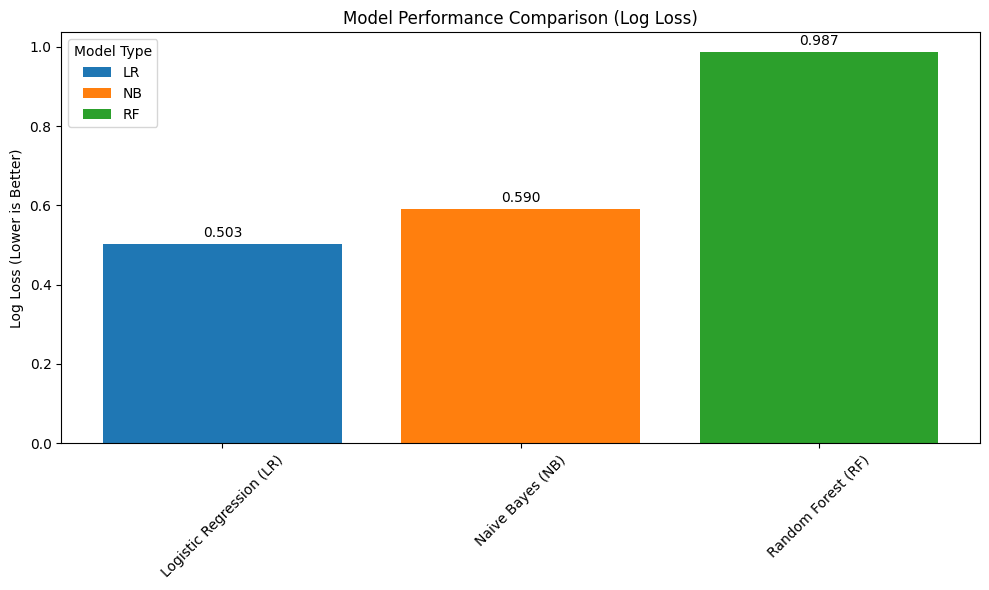

In [92]:

# Compare all three models
models = ["Logistic Regression (LR)", "Naive Bayes (NB)", "Random Forest (RF)"]
logLosses = [lr_logloss, nb_logloss, rf_logLoss]

# Create figure and axis
fig, ax = plt.subplots(figsize=(10,6))

# Data
bar_labels = ["LR", "NB", "RF"]
bar_colors = ["tab:blue", "tab:orange", "tab:green"]

# Create bar chart
bars = ax.bar(models, logLosses, label=bar_labels, color=bar_colors)

ax.set_ylabel('Log Loss (Lower is Better)')
ax.set_title("Model Performance Comparison (Log Loss)")
ax.legend(title="Model Type")

# Add bar value labels
ax.bar_label(bars, fmt="%.3f", padding=3)

plt.xticks(rotation=45) # rotate model labels 45 degrees
plt.tight_layout() # improves layout
plt.show()

## 5. Kaggle Submission

5.1 Final Pipeline - Retraining & Generating Predictions
- Logistic regression was the top performing classifier
- Hardcode LR and its best param values into the final pipeline
- Pipeline is retrained on the full kaggle training file  - k_trainDF
- k_testDF (the unlabelled test set) is transformed by the trained pipeline to generate probability predictions

In [33]:

# Final Logistic Regression implementation with best values
logisticRegression = LogisticRegression(
    featuresCol="tfidfFeatures", 
    labelCol="authorIndex",
    regParam=0.09,
    elasticNetParam=0.0
)

# Update final vocab size
countVec.setVocabSize(11500)

# Build final pipeline with tuned LR
pipeline = buildPipeline(logisticRegression)

# Train the model on the full train file
trainedPL = pipeline.fit(k_trainDF)

# Final predictions based on full test file
final_preds = trainedPL.transform(k_testDF)
final_preds.select("id", "text", "prediction", "probability").show(5)

+-------+--------------------+----------+--------------------+
|     id|                text|prediction|         probability|
+-------+--------------------+----------+--------------------+
|id02310|Still, as I urged...|       1.0|[0.18296819602174...|
|id24541|If a fire wanted ...|       0.0|[0.80884501710316...|
|id00134|And when they had...|       2.0|[0.22723491774654...|
|id27757|While I was think...|       0.0|[0.64116733942651...|
|id04081|I am not sure to ...|       0.0|[0.82512445204852...|
+-------+--------------------+----------+--------------------+
only showing top 5 rows



5.2 Create Kaggle Submission File
- Check label ordering matches Kaggles submission requirements
- Organise columns
- Create submission CSV file

In [34]:

# Label ordering - ensure authors are in correct order for competition submission
string_indexer = trainedPL.stages[4] # si (string indexer) at index 4 of pipeline
labelOrder = string_indexer.labels
print("Label Order:", labelOrder)

kaggleDF = (
    final_preds
        .withColumn("probArray", vector_to_array(col("probability")))
        .withColumn("EAP", col("probArray")[labelOrder.index("EAP")])
        .withColumn("MWS", col("probArray")[labelOrder.index("MWS")])
        .withColumn("HPL", col("probArray")[labelOrder.index("HPL")])
        .select("id", "EAP", "MWS", "HPL")
)

# Review final submission DF
kaggleDF.show(10, truncate=False)

# Convert to Pandas Dataframe
kagglePD = kaggleDF.toPandas()

# Uncomment to create Kaggle submission file
kagglePD.to_csv("../output/predictions.csv", index=False)

Label Order: ['EAP', 'MWS', 'HPL']
+-------+-------------------+---------------------+--------------------+
|id     |EAP                |MWS                  |HPL                 |
+-------+-------------------+---------------------+--------------------+
|id02310|0.18296819602174003|0.7487365415310857   |0.06829526244717436 |
|id24541|0.8088450171031607 |0.02242042415391234  |0.16873455874292706 |
|id00134|0.22723491774654564|0.017042070885065444 |0.755723011368389   |
|id27757|0.6411673394265132 |0.011069233892187558 |0.3477634266812995  |
|id04081|0.8251244520485219 |0.10394573009778375  |0.07092981785369432 |
|id27337|0.37854621761250484|0.037571662406785604 |0.5838821199807096  |
|id24265|0.571101027939795  |0.12298365150690381  |0.3059153205533012  |
|id25917|0.17727016218209124|0.5615927718920545   |0.2611370659258542  |
|id04951|0.9720447736978796 |0.0021756778386387288|0.025779548463481603|
|id14549|0.7015086026962907 |0.16882870057806368  |0.12966269672564565 |
+-------+-------